In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import preprocessing_utils as helper

%matplotlib inline

In [8]:
# Directory setup
BASE_DIR = '..'

TFRECORDS_DIR = '../data/lsms_tfrecords_raw/'
LSMS_CSV_PATH = '../data/lsms_clusters.csv'

EXPORT_DIR = '../data/lsms_tfrecords/'

In [4]:
# avg_rad is the nightlights band
BANDS = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'avg_rad']

In [5]:
df_lsms = pd.read_csv(LSMS_CSV_PATH)

# Type conversion to float32
df_lsms['lat'] = df_lsms['lat'].astype(np.float32)
df_lsms['lon'] = df_lsms['lon'].astype(np.float32)
df_lsms['consumption'] = df_lsms['consumption'].astype(np.float32)

print(df_lsms.dtypes)
display(df_lsms)

country         object
consumption    float32
density          int64
lat            float32
lon            float32
dtype: object


,country,consumption,density,lat,lon
0,ethiopia,7.114359,0,13.522697,39.440907
1,ethiopia,6.933496,1,9.602403,41.866592
2,ethiopia,7.354854,1,11.294477,36.448727
3,ethiopia,1.129382,1,9.503581,42.070496
4,ethiopia,1.924262,1,8.970294,36.525711
...,...,...,...,...,...
6508,ethiopia,4.283961,1,9.600062,41.245560
6509,ethiopia,2.158788,0,9.062462,38.757240
6510,ethiopia,1.986287,0,10.821666,40.187645
6511,ethiopia,2.943372,1,11.800598,37.128471


In [11]:
tfrecords = sorted([f for f in os.listdir(EXPORT_DIR) if not f.startswith('.')])

for tf_r in tfrecords:
    sample_tfrecord = EXPORT_DIR + tf_r
    
    feature_set = helper.create_single_feature_set(filename=sample_tfrecord)
    feature_array = helper.get_feature_array(feature_set=feature_set)
    
    if (feature_array['lat'] == 9.346658 and feature_array['lon'] == 42.075893):
        print(tf_r)
    

# First TFRecord path
sample_tfrecord = TFRECORDS_DIR + 'ethiopia_00.tfrecord'

# Get feature array of first record
feature_set = helper.create_single_feature_set(filename=sample_tfrecord)
helper.get_feature_array(feature_set=feature_set)

{'country': ('bytes_list', (1,)),
 'density': ('float_list', (1,)),
 'BLUE': ('float_list', (65025,)),
 'consumption': ('float_list', (1,)),
 'lon': ('float_list', (1,)),
 'LON': ('float_list', (65025,)),
 'GREEN': ('float_list', (65025,)),
 'RED': ('float_list', (65025,)),
 'TEMP': ('float_list', (65025,)),
 'SW_IR1': ('float_list', (65025,)),
 'NIR': ('float_list', (65025,)),
 'SW_IR2': ('float_list', (65025,)),
 'avg_rad': ('float_list', (65025,)),
 'lat': ('float_list', (1,)),
 'LAT': ('float_list', (65025,)),
 'system:index': ('bytes_list', (1,))}

ethiopia: 13.522697, 39.440907


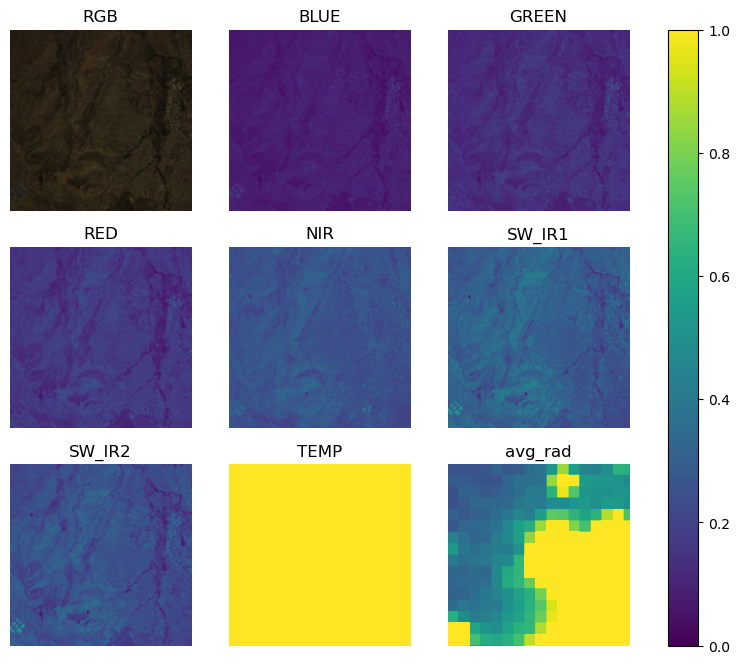

In [33]:
def view_single_record_bands(feature_set):
    lat = np.float32(feature_set['lat'].float_list.value[0])
    lon = np.float32(feature_set['lon'].float_list.value[0])
    country = feature_set['country'].bytes_list.value[0].decode()
    
    band_images = []
    for band_id, band_name in enumerate(BANDS):
        band = np.array(feature_set[band_name].float_list.value, dtype=np.float32).reshape(255, 255)
        band_images.append(band)
    band_images = np.stack(band_images, axis=2)
    
    print(f'{country}: {lat:4f}, {lon:4f}')
    helper.visualize_bands(img=band_images, band_names=BANDS, bands_per_row=3)
    
    
view_single_record_bands(feature_set=feature_set)

In [449]:
REQUIRED_KEYS = [
    'BLUE', 'GREEN', 'LAT', 'LON', 'avg_rad', 'NIR', 'RED', 'SW_IR1', 'SW_IR2', 'TEMP', 'lat',
    'lon', 'consumption', 'density', 'country'
]

def validate_record(feature_set, record_name):
    # Check for missing bands
    missing_req_keys = [key for key in REQUIRED_KEYS if key not in feature_set]
    if len(missing_req_keys) > 0:
        print(f'Record {record_name} missing required keys: {missing_req_keys}')
        return False
    
    lon = np.float32(feature_set['lon'].float_list.value[0])
    lat = np.float32(feature_set['lat'].float_list.value[0])
    
    # Check middle pixel coordinates
    img_lon = np.float32(np.asarray(feature_set['LON'].float_list.value).reshape(255, 255)[127, 127])
    img_lat = np.float32(np.asarray(feature_set['LAT'].float_list.value).reshape(255, 255)[127, 127])

    if abs(lon - img_lon) > 1e-3:
        print(f'Record {record_name} contains mismatch: "lon"={lon}, "LON"={img_lon}')
        return False
    if abs(lat - img_lat) > 1e-3:
        print(f'Record {record_name} contains invalid lat. "lat"={lat}, "LAT"={img_lat}')
        return False

def process_tfrecords(tfrecord_path, export_dir):
    # Incorrect sorting, solely for visual purposes
    tfrecords = sorted([f for f in os.listdir(tfrecord_path) if not f.startswith('.')])
    
    num_good_records = 0
    for tf_i, tf_r in enumerate(tfrecords):
        filename = tfrecord_path + tf_r
        dataset = tf.data.TFRecordDataset(filenames=[filename])
        
        # Splits each TFRecord file into seperate record files
        for record_i, record in enumerate(iter(dataset)):
            example = tf.train.Example.FromString(record.numpy())
            feature_set = example.features.feature
            
            record_name = f'ethiopia_{tf_i}_{record_i}'
            is_good_record = validate_record(feature_set=feature_set, record_name=record_name)
            
            if is_good_record != False:    
                # Seralize contents of processed record and write
                os.makedirs(export_dir, exist_ok=True)
                export_path = export_dir + f'/{record_name}' + '.tfrecord'
                
                with tf.io.TFRecordWriter(export_path) as writer:
                    writer.write(example.SerializeToString())
                num_good_records += 1
            
            if (record_i + 1) % 25 == 0:
                print(f'Finished validating {record_i + 1} records')
        
        print(f'Finished validating TFRecord {tf_i + 1}')


In [450]:
process_tfrecords(tfrecord_path=TFRECORDS_DIR, export_dir=EXPORT_DIR)

Finished validating 25 records
Finished validating TFRecord 1
Finished validating 25 records
Finished validating TFRecord 2
Finished validating 25 records
Finished validating TFRecord 3
Finished validating 25 records
Finished validating TFRecord 4
Finished validating 25 records
Finished validating TFRecord 5
Finished validating 25 records
Finished validating TFRecord 6
Finished validating 25 records
Finished validating TFRecord 7
Finished validating 25 records
Finished validating TFRecord 8
Finished validating 25 records
Finished validating TFRecord 9
Finished validating 25 records
Finished validating TFRecord 10
Finished validating 25 records
Finished validating TFRecord 11
Finished validating 25 records
Finished validating TFRecord 12
Finished validating 25 records
Finished validating TFRecord 13
Finished validating 25 records
Finished validating TFRecord 14
Finished validating 25 records
Finished validating TFRecord 15
Finished validating 25 records
Finished validating TFRecord 16
F

Finished validating 25 records
Finished validating TFRecord 131
Finished validating 25 records
Finished validating TFRecord 132
Finished validating 25 records
Finished validating TFRecord 133
Finished validating 25 records
Finished validating TFRecord 134
Finished validating 25 records
Finished validating TFRecord 135
Finished validating 25 records
Finished validating TFRecord 136
Finished validating 25 records
Finished validating TFRecord 137
Finished validating 25 records
Finished validating TFRecord 138
Finished validating 25 records
Finished validating TFRecord 139
Finished validating 25 records
Finished validating TFRecord 140
Finished validating 25 records
Finished validating TFRecord 141
Finished validating 25 records
Finished validating TFRecord 142
Finished validating 25 records
Finished validating TFRecord 143
Finished validating 25 records
Finished validating TFRecord 144
Finished validating 25 records
Finished validating TFRecord 145
Finished validating 25 records
Finished 

Finished validating 25 records
Finished validating TFRecord 260
Finished validating 25 records
Finished validating TFRecord 261
